In [ ]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

In [ ]:
# we need pillow version of 5.3.0
# we will uninstall the older version first
!pip uninstall -y Pillow
# install the new one
!pip install Pillow==5.3.0
# import the new one
import PIL
print(PIL.PILLOW_VERSION)
# this should print 5.3.0. If it doesn't, then restart your runtime:
# Menu > Runtime > Restart Runtime

Uninstalling Pillow-5.3.0:
  Successfully uninstalled Pillow-5.3.0
  Using cached https://files.pythonhosted.org/packages/62/94/5430ebaa83f91cc7a9f687ff5238e26164a779cca2ef9903232268b0a318/Pillow-5.3.0-cp36-cp36m-manylinux1_x86_64.whl
5.3.0


In [ ]:
# we will download the required data files
!wget -cq https://github.com/udacity/pytorch_challenge/raw/master/cat_to_name.json
!wget -cq https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip
!rm -r flower_data || true
!unzip -qq flower_data.zip

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import re
import seaborn as sns
import json
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from torchvision import datasets, models, transforms
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division
from collections import OrderedDict
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(30),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [ ]:
data_dir = 'flower_data'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'valid']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'valid']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
with open('cat_to_name.json', 'r') as f:
  label_map = json.load(f)
  print(label_map)

{'21': 'fire lily', '3': 'canterbury bells', '45': 'bolero deep blue', '1': 'pink primrose', '34': 'mexican aster', '27': 'prince of wales feathers', '7': 'moon orchid', '16': 'globe-flower', '25': 'grape hyacinth', '26': 'corn poppy', '79': 'toad lily', '39': 'siam tulip', '24': 'red ginger', '67': 'spring crocus', '35': 'alpine sea holly', '32': 'garden phlox', '10': 'globe thistle', '6': 'tiger lily', '93': 'ball moss', '33': 'love in the mist', '9': 'monkshood', '102': 'blackberry lily', '14': 'spear thistle', '19': 'balloon flower', '100': 'blanket flower', '13': 'king protea', '49': 'oxeye daisy', '15': 'yellow iris', '61': 'cautleya spicata', '31': 'carnation', '64': 'silverbush', '68': 'bearded iris', '63': 'black-eyed susan', '69': 'windflower', '62': 'japanese anemone', '20': 'giant white arum lily', '38': 'great masterwort', '4': 'sweet pea', '86': 'tree mallow', '101': 'trumpet creeper', '42': 'daffodil', '22': 'pincushion flower', '2': 'hard-leaved pocket orchid', '54': 's

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


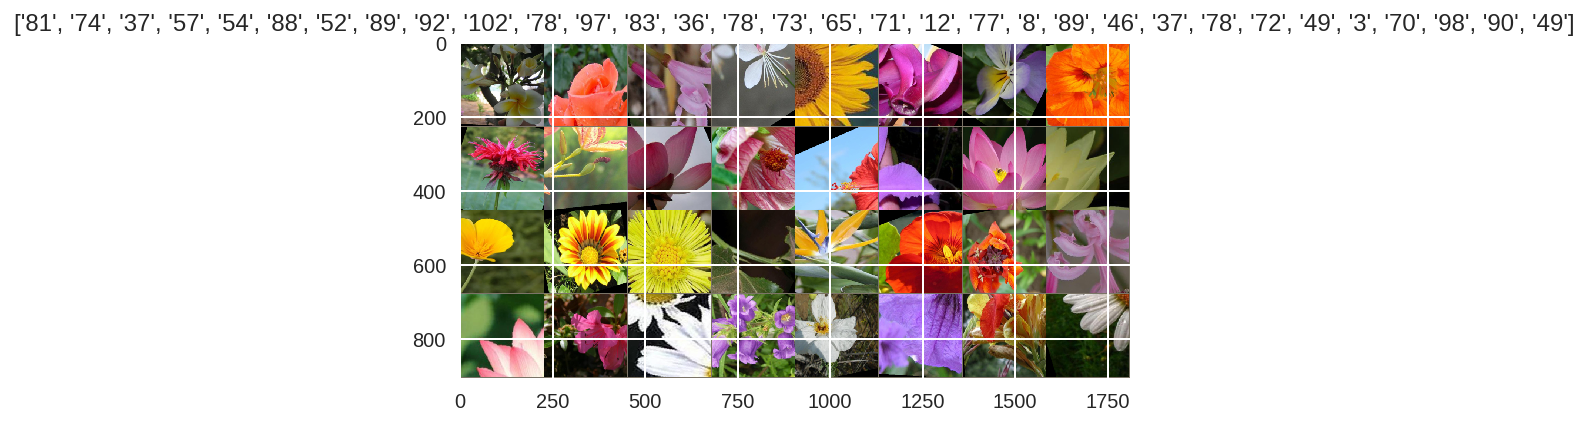

In [ ]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
model = torchvision.models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
classifier = nn.Sequential(OrderedDict([
                           ('fc1', nn.Linear(num_ftrs, 1028)),
                           ('relu1', nn.ReLU()),
                           ('dropout1', nn.Dropout(0.2)),
                           ('fc2', nn.Linear(1028, 512)),
                           ('relu2', nn.ReLU()),
                           ('dropout2', nn.Dropout(0.2)),
                           ('fc3', nn.Linear(512 ,102)),
                           ('output', nn.LogSoftmax(dim =1))]))

In [ ]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [ ]:
for param in model.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
model.fc = classifier

In [ ]:
def train_model(model, criteria, optimizer, scheduler, num_epochs=25, device='cuda'):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer = optim.SGD(model.fc.parameters(), lr=0.01, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
model = train_model(model, criterion, optimizer, scheduler, num_epochs = 30, device = 'cuda')

Epoch 0/29
----------
train Loss: 3.9806 Acc: 0.1371
valid Loss: 2.7059 Acc: 0.3484

Epoch 1/29
----------
train Loss: 2.0796 Acc: 0.4660
valid Loss: 1.1456 Acc: 0.6626

Epoch 2/29
----------
train Loss: 1.3837 Acc: 0.6213
valid Loss: 0.6931 Acc: 0.8020

Epoch 3/29
----------
train Loss: 1.0865 Acc: 0.7024
valid Loss: 0.6285 Acc: 0.8130

Epoch 4/29
----------
train Loss: 0.9918 Acc: 0.7222
valid Loss: 0.5596 Acc: 0.8289

Epoch 5/29
----------
train Loss: 0.8967 Acc: 0.7514
valid Loss: 0.4978 Acc: 0.8570

Epoch 6/29
----------
train Loss: 0.8225 Acc: 0.7726
valid Loss: 0.4386 Acc: 0.8680

Epoch 7/29
----------
train Loss: 0.5755 Acc: 0.8411
valid Loss: 0.2961 Acc: 0.9181

Epoch 8/29
----------
train Loss: 0.5323 Acc: 0.8545
valid Loss: 0.2867 Acc: 0.9205

Epoch 9/29
----------
train Loss: 0.5231 Acc: 0.8542
valid Loss: 0.2713 Acc: 0.9267

Epoch 10/29
----------
train Loss: 0.5099 Acc: 0.8559
valid Loss: 0.2732 Acc: 0.9267

Epoch 11/29
----------
train Loss: 0.4974 Acc: 0.8594
valid Loss

In [ ]:
def calc_accuracy(model, data, cuda=False):
    model.eval()
    model.to(device='cuda')    
    
    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(dataloaders[data]):
            if cuda:
                inputs, labels = inputs.cuda(), labels.cuda()
            # obtain the outputs from the model
            outputs = model.forward(inputs)
            # max provides the (maximum probability, max value)
            _, predicted = outputs.max(dim=1)
            # check the 
            if idx == 0:
                print(predicted) #the predicted class
                print(torch.exp(_)) # the predicted probability
            equals = predicted == labels.data
            if idx == 0:
                print(equals)
            print(equals.float().mean())

In [1]:
#calc_accuracy(model, 'valid', True)

In [ ]:
#to save model from colab to drive
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 110842 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.1-0ubuntu3~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.1-0ubuntu3~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.1-0ubuntu3~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=ht

In [ ]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [ ]:
#torch.save(model.state_dict(), 'drive/Colab Notebooks/model.pth')
model.class_to_idx = image_datasets['train'].class_to_idx
model.cpu()
torch.save({'arch': 'resnet50',
           'state_dict': model.state_dict(),
           'class_to_idx': model.class_to_idx},
           'drive/Colab Notebooks/classifier.pth')

In [ ]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
def load_model(checkpoint_path):
    chpt = torch.load(checkpoint_path)
    if chpt['arch'] == 'resnet50':
        for param in model.parameters():
            param.requires_grad = False
    else:
        print('Sorry base architecture not recognized')
    model.class_to_idx = chpt['class_to_idx']
    classifier = nn.Sequential(OrderedDict([
                               ('fc1', nn.Linear(num_ftrs, 1028)),
                               ('relu1', nn.ReLU()),
                               ('dropout1', nn.Dropout(0.2)),
                               ('fc2', nn.Linear(1028, 512)),
                               ('relu2', nn.ReLU()),
                               ('dropout2', nn.Dropout(0.2)),
                               ('fc3', nn.Linear(512 ,102)),
                               ('output', nn.LogSoftmax(dim =1))]))
    model.fc = classifier
    model.load_state_dict(chpt['state_dict'])
    return model

In [ ]:
model = load_model('drive/Colab Notebooks/classifier.pth')
calc_accuracy(model, 'valid', True)


tensor([ 2,  3, 97, 52, 74, 49, 44, 43, 12, 20, 18,  4, 96, 82, 77, 29, 98, 83,
        43, 16, 25, 59, 12, 78, 76, 82, 36, 90, 80, 97, 73, 52],
       device='cuda:0')
tensor([0.9994, 0.4224, 0.9996, 0.9999, 0.9840, 0.9797, 0.9933, 0.9997, 0.9990,
        0.9920, 0.7659, 0.9888, 0.9988, 1.0000, 1.0000, 0.9953, 0.6998, 0.9805,
        0.9996, 1.0000, 0.6572, 1.0000, 0.9989, 0.9987, 0.8971, 0.9999, 0.9354,
        0.9998, 0.9955, 0.9984, 0.9915, 0.9721], device='cuda:0')
tensor([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0', dtype=torch.uint8)
tensor(0.9375, device='cuda:0')
tensor(0.9375, device='cuda:0')
tensor(1., device='cuda:0')
tensor(0.8438, device='cuda:0')
tensor(0.9688, device='cuda:0')
tensor(0.9688, device='cuda:0')
tensor(1., device='cuda:0')
tensor(0.9688, device='cuda:0')
tensor(0.9375, device='cuda:0')
tensor(0.9062, device='cuda:0')
tensor(0.9375, device='cuda:0')
tensor(1., device='cuda:0')
tens

In [ ]:
def process_image(image_path):
    ''' 
    Scales, crops, and normalizes a PIL image for a PyTorch       
    model, returns an Numpy array
    '''
    # Open the image
    from PIL import Image
    img = Image.open(image_path)
    # Resize
    if img.size[0] > img.size[1]:
        img.thumbnail((10000, 256))
    else:
        img.thumbnail((256, 10000))
    # Crop 
    left_margin = (img.width-224)/2
    bottom_margin = (img.height-224)/2
    right_margin = left_margin + 224
    top_margin = bottom_margin + 224
    img = img.crop((left_margin, bottom_margin, right_margin,   
                      top_margin))
    # Normalize
    img = np.array(img)/255
    mean = np.array([0.485, 0.456, 0.406]) #provided mean
    std = np.array([0.229, 0.224, 0.225]) #provided std
    img = (img - mean)/std
    
    # Move color channels to first dimension as expected by PyTorch
    img = img.transpose((2, 0, 1))    
    return img

In [ ]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    if title:
        plt.title(title)
    # PyTorch tensors assume the color channel is first
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

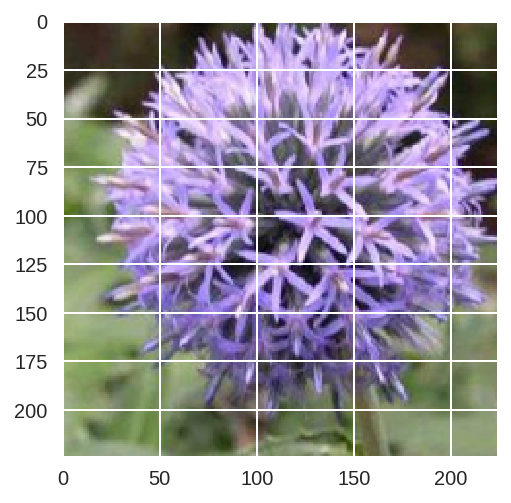

In [ ]:
image_path = 'flower_data/valid/10/image_07094.jpg'
img = process_image(image_path)
imshow(img)

In [ ]:
def predict(image_path, model, top_num=5):
    # Process image
    img = process_image(image_path)
    
    # Numpy -> Tensor
    image_tensor = torch.from_numpy(img).type(torch.FloatTensor)
    # Add batch of size 1 to image
    model_input = image_tensor.unsqueeze(0)
    
    # Probs
    probs = torch.exp(model.forward(model_input))
    
    # Top probs
    top_probs, top_labs = probs.topk(top_num)
    top_probs = top_probs.detach().numpy().tolist()[0] 
    top_labs = top_labs.detach().numpy().tolist()[0]
    
    # Convert indices to classes
    idx_to_class = {val: key for key, val in    
                                      model.class_to_idx.items()}
    top_labels = [idx_to_class[lab] for lab in top_labs]
    top_flowers = [label_map[idx_to_class[lab]] for lab in top_labs]
    return top_probs, top_labels, top_flowers

In [ ]:
def plot_solution(image_path, model):
    # Set up plot
    plt.figure(figsize = (6,10))
    ax = plt.subplot(2,1,1)
    # Set up title
    #flower_num = image_path.split('/valid/')[-1]
    
    flower_num = re.findall(r'\d+', image_path)[0]
    title_ = label_map[flower_num]
    # Plot flower
    img = process_image(image_path)
    imshow(img, ax, title = title_);
    # Make prediction
    top_probs, top_labels, top_flowers = predict(image_path, model) 
    # Plot bar chart
    plt.subplot(2,1,2)
    sns.barplot(x=top_probs, y = top_flowers , color=sns.color_palette()[0]);

    plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


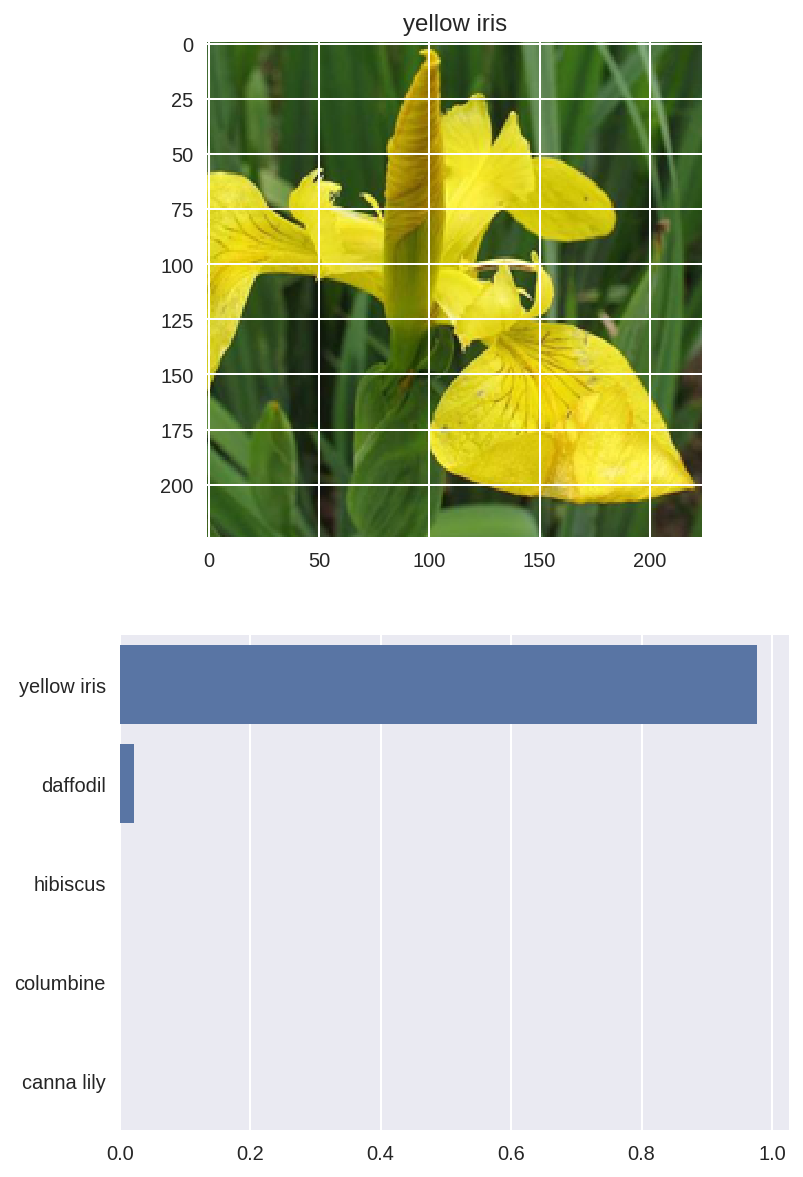

In [ ]:
model.cpu()
image_path = 'flower_data/train/15/image_06347.jpg'
plot_solution(image_path, model)